In [3]:
import os
import itertools
import codecs
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def paint_text(text, w, h, rotate=False, ud=False, multi_fonts=False):
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)
    with cairo.Context(surface) as context:
        context.set_source_rgb(1, 1, 1)  # White
        context.paint()
        # this font list works in CentOS 7
        
        context.select_font_face('Courier',
                                     cairo.FONT_SLANT_NORMAL,
                                     cairo.FONT_WEIGHT_BOLD)
        context.set_font_size(25)
        box = context.text_extents(text)
        border_w_h = (4, 4)
        if box[2] > (w - 2 * border_w_h[1]) or box[3] > (h - 2 * border_w_h[0]):
            raise IOError(('Could not fit string into image.'
                           'Max char count is too large for given image width.'))

        # teach the RNN translational invariance by
        # fitting text box randomly on canvas, with some room to rotate
        max_shift_x = w - box[2] - border_w_h[0]
        max_shift_y = h - box[3] - border_w_h[1]
        top_left_x = np.random.randint(0, int(max_shift_x))
        if ud:
            top_left_y = np.random.randint(0, int(max_shift_y))
        else:
            top_left_y = h // 2
        context.move_to(top_left_x - int(box[0]), top_left_y - int(box[1]))
        context.set_source_rgb(0, 0, 0)
        context.show_text(text)

    buf = surface.get_data()
    a = np.frombuffer(buf, np.uint8)
    a.shape = (h, w, 4)
    a = a[:, :, 0]  # grab single channel
    a = a.astype(np.float32) / 255
    a = np.expand_dims(a, 0)
    if rotate:
        a = image.random_rotation(a, 3 * (w - top_left_x) / w + 1)
    #a = speckle(a)

    return a

In [6]:
# character classes and matching regex filter
regex = r'^[a-e ]+$'
alphabet = u'abcde'

In [7]:
index = np.random.randint(0,5,size=[4])

In [8]:
index

array([4, 4, 0, 1])

In [24]:
string = ""
label = []

In [25]:
for i in range(4):
    string = string + alphabet[index[i]]
    label.append(alphabet[index[i]])
    
    

In [26]:
string

'eeab'

In [23]:
label

['e', 'e', 'a', 'b', 'e', 'e', 'a', 'b']

In [58]:
def string_create(size):
    alphabet = u'abcde'
    index = np.random.randint(0,5,size=[size])
    string = ""
    label = []
    for i in range(size):
        string = string + alphabet[index[i]]
        label.append(index[i])
        
    return string,label,len(label)
    
    
    

In [59]:
string1,label1,len_label = string_create(4)

In [60]:
string1

'cdbb'

In [61]:
label1

[2, 3, 1, 1]

In [31]:
len_label

4

In [36]:
img = paint_text(string1,w=128,h=64)

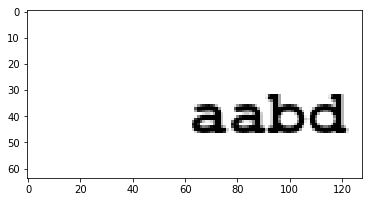

In [39]:
plt.imshow(img[0,:,:],cmap="gray")

In [40]:
img.shape

(1, 64, 128)

In [41]:
img2 = img.T

In [42]:
img2.shape

(128, 64, 1)

In [44]:
img_w = 128
img_h = 64

In [46]:
absolute_max_string_len = 4

In [43]:
batch_size = 32

In [101]:
def next_batch():
    
    # image
    X_data = np.ones([batch_size,img_w,img_h,1])
    
    # labels
    labels = np.ones([batch_size,absolute_max_string_len])
    
    #input length
    input_length = np.zeros([batch_size, 1])
    
    # label_length
    label_length = np.zeros([batch_size, 1])
    
    for i in range(batch_size):
        
        string,label,len_label = string_create(absolute_max_string_len)
        
        X_data[i,0:img_w,:,0] = paint_text(string,w=img_w,h=img_h)[0,:,:].T
        
        labels[i] = label
        
        input_length[i] = img_w//4 -2
        
        label_length[i] = len_label
        
        
    inputs =  {'the_input': X_data,
                  'the_labels': labels,
                  'input_length': input_length,
                  'label_length': label_length,
                  }

    outputs = {'ctc': np.zeros([batch_size])}
    
    yield (inputs, outputs)

    
    

In [100]:
x

<generator object next_batch at 0x7fa4cef48468>

In [70]:
from scipy import ndimage
import pylab
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks

Using TensorFlow backend.


In [72]:
# Network parameters
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
batch_size = 32

In [76]:
input_shape = (img_w, img_h, 1)
act = 'relu'

In [78]:
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2),
                        (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True,
                kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True,
                 go_backwards=True, kernel_initializer='he_normal',
                 name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True,
                kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,
                 kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(len(alphabet)+1, kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)
    
Model(inputs=input_data, outputs=y_pred).summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [79]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [103]:
labels = Input(name='the_labels',shape=[absolute_max_string_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

In [105]:
loss_out = Lambda(
        ctc_lambda_func, output_shape=(1,),
        name='ctc')([y_pred, labels, input_length, label_length])

In [106]:
# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

In [107]:
model = Model(inputs=[input_data, labels, input_length, label_length],outputs=loss_out)

In [108]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [109]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

In [110]:
model.fit_generator(
        generator=next_batch(),
        steps_per_epoch=(32*6) // batch_size,
        epochs=20,
        validation_data=next_batch(),
        validation_steps=(32*2) // batch_size,
        initial_epoch=0)

Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[32,16,128,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv1_1/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@training_1/SGD/cond/Switch_2"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1_1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss_1/mul/_337 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_5344_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [92]:
model.fit_generator(
        generator=next_batch(),
        epochs=20,
        steps_per_epoch =15,
        initial_epoch=0)

Epoch 1/20


AttributeError: 'int' object has no attribute 'shape'

In [93]:
x= next_batch()

In [95]:
x[0].shape

TypeError: 'generator' object is not subscriptable